<a href="https://colab.research.google.com/github/llwusill/BrainTumorDetection/blob/main/BRAIN_MR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/BRAIN_MR

/content/drive/MyDrive/BRAIN_MR


###1. Data Hazırlığı


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
HOME = os.getcwd()
print(HOME)

/content/drive/MyDrive/BRAIN_MR


In [ ]:
path = f'{HOME}/brain_mri_scan_images'

data_path = path.split(os.sep)

main_path = os.getcwd().split(os.sep)

In [ ]:
os.listdir(os.sep.join(data_path))

['positive', 'negative']

### Pozitif ve Negatif görsellerin dosyaya atanması

In [ ]:
positive_dir = data_path + ['positive']

negative_dir = data_path + ['negative']

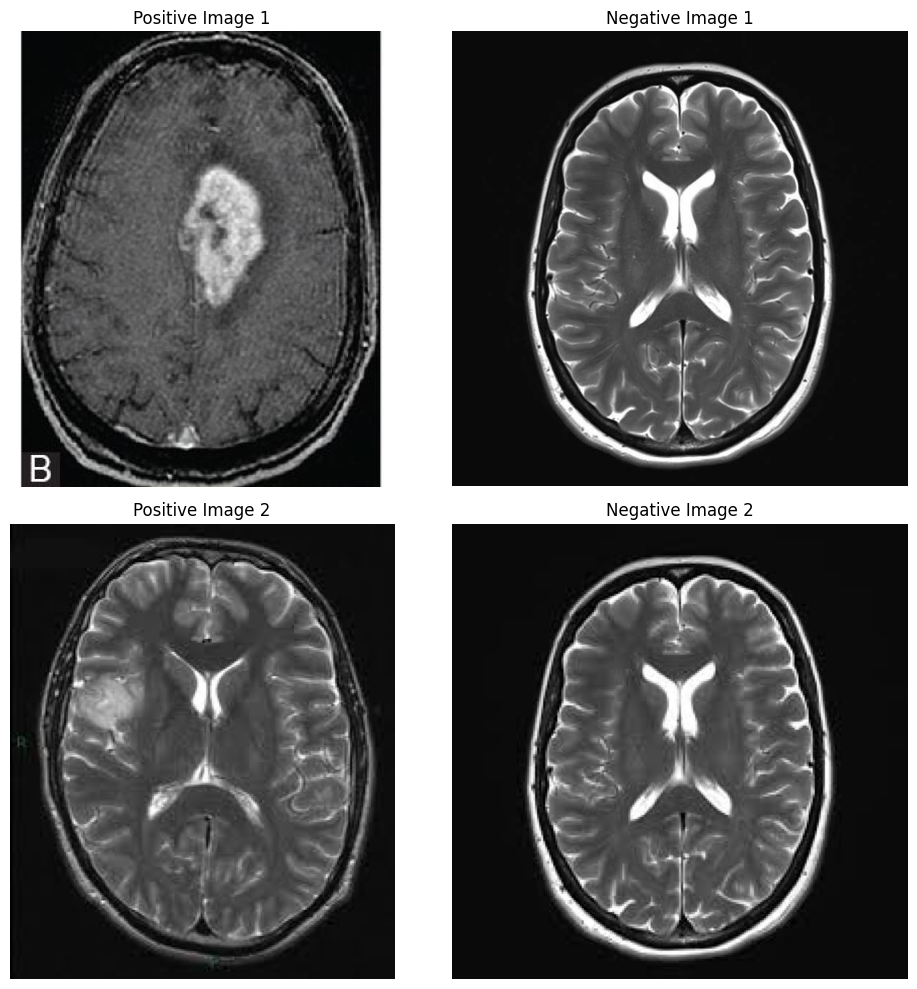

In [ ]:
import matplotlib.pyplot as plt
import random

random_positive_images = random.sample(os.listdir(os.sep.join(positive_dir)), 2)
random_negative_images = random.sample(os.listdir(os.sep.join(negative_dir)), 2)

pos_img_1 = plt.imread(os.sep.join(positive_dir + [random_positive_images[0]]))
pos_img_2 = plt.imread(os.sep.join(positive_dir + [random_positive_images[1]]))
neg_img_1 = plt.imread(os.sep.join(negative_dir + [random_negative_images[0]]))
neg_img_2 = plt.imread(os.sep.join(negative_dir + [random_negative_images[1]]))

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(pos_img_1)
plt.title('Positive Image 1')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(pos_img_2)
plt.title('Positive Image 2')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(neg_img_1)
plt.title('Negative Image 1')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(neg_img_2)
plt.title('Negative Image 2')
plt.axis('off')

plt.tight_layout()
plt.show()

Artırılmış pozifitif ve negatif görüntüler elimizdeki görsellerrin döndürülmüş , ölçeklendirilmiş, gürültülü ya da yeniden boyulatlandırılmış halidir.

In [ ]:
augmented_images_pos = 'augmented_images_pos'
augmented_images_neg = 'augmented_images_neg'

os.mkdir(os.path.join(os.sep.join(main_path), augmented_images_pos))

os.mkdir(os.path.join(os.sep.join(main_path), augmented_images_neg))

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
%%time
for dosya in os.listdir(os.sep.join(positive_dir)):
    img_path = os.sep.join(positive_dir + [dosya])

    img = load_img(img_path)

    x = img_to_array(img)

    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=os.path.join(os.sep.join(main_path), augmented_images_pos),
                              save_prefix='tumor', save_format='jpeg'):
        i += 1
        if i > 20:
            break

CPU times: user 1min 38s, sys: 1.75 s, total: 1min 40s
Wall time: 1min 52s


In [ ]:
%%time
for dosya in os.listdir(os.sep.join(negative_dir)):

    img_path = os.sep.join(negative_dir + [dosya])


    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)


    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=os.path.join(os.sep.join(main_path), augmented_images_neg),
                              save_prefix='tumor', save_format='jpeg'):
        i += 1

        if i > 20:
            break

CPU times: user 1min 3s, sys: 621 ms, total: 1min 4s
Wall time: 1min 56s


In [ ]:
random_augmented_pos_image = random.sample(os.listdir(os.sep.join((os.path.join(os.sep.join(main_path)),augmented_images_pos))),1)
random_augmented_neg_image = random.sample(os.listdir(os.sep.join((os.path.join(os.sep.join(main_path)), augmented_images_neg))),1)

##Artırılmış Görüntülerden Rastgele Seçim ve Seçilen Görüntülerin Okunması

In [ ]:
aug_pos_img = plt.imread(os.path.join(os.sep.join(main_path), augmented_images_pos, random_augmented_pos_image[0]))
aug_neg_img = plt.imread(os.path.join(os.sep.join(main_path), augmented_images_neg, random_augmented_neg_image[0]))

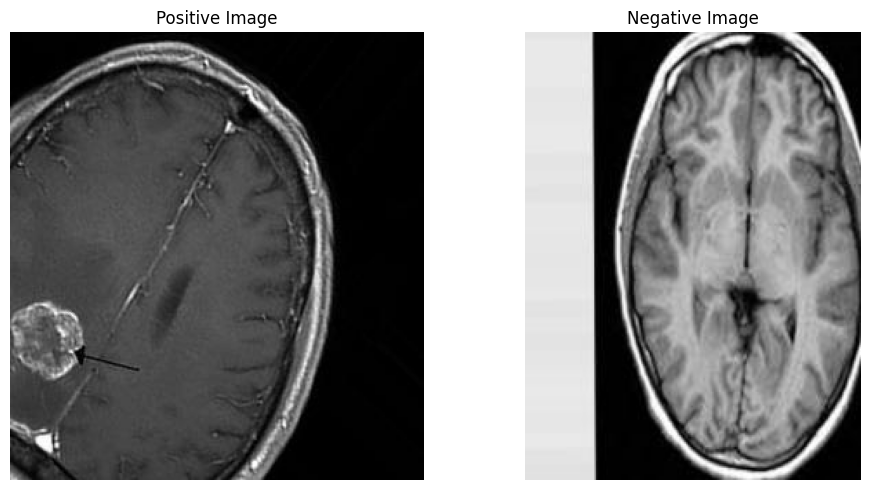

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(aug_pos_img)
plt.title('Positive Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(aug_neg_img)
plt.title('Negative Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def load_images_and_normalize(dir_path):
    images = []


    for file in os.listdir(dir_path):
        img_path = os.path.join(dir_path, file)

        img = load_img(img_path, target_size=(150, 150))

        img_array = img_to_array(img)
        images.append(img_array)

    images = np.array(images, dtype=np.float32) / 255.0
    return images

In [ ]:
%%time
positive_images = load_images_and_normalize(os.path.join(os.sep.join(main_path), augmented_images_pos))

negative_images = load_images_and_normalize(os.path.join(os.sep.join(main_path), augmented_images_neg))

CPU times: user 4.34 s, sys: 1.04 s, total: 5.38 s
Wall time: 39.7 s


###2. Model Mimarisi ve Dizaynı

In [ ]:
def simple_cnn_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))


    model.add(Dense(1, activation='sigmoid'))

    return model

###3. Modelin Derlenmesi

 * Optimizer, modelin ağırlıklarını güncelleyerek öğrenmesini sağlayan algoritmadır. adam, yaygın olarak kullanılan bir optimizördür ve genellikle iyi performans gösterir.

 * Loss fonksiyonu, modelin tahminlerinin gerçek değerlerden ne kadar uzakta olduğunu ölçen bir metriktir. "binary_crossentropy", iki sınıflı sınıflandırma problemleri için uygun bir loss fonksiyonudur.

 * Metric'ler, modelin performansını değerlendirmek için kullanılan ek ölçümlerdir. accuracy, tahminlerin doğruluk yüzdesini hesaplayan yaygın bir metriktir.


In [ ]:
model = simple_cnn_model((150, 150, 3))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:

positive_labels = np.ones(positive_images.shape[0])
negative_labels = np.zeros(negative_images.shape[0])


X = np.concatenate([positive_images, negative_images])
y = np.concatenate([positive_labels, negative_labels])

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

###4. Model Eğitimi

```ptyhon
early stopping: mekanizmasını ayarlar. Bu mekanizma,
modelin doğrulama kaybı (val_loss) artmaya başladığında
eğitimi erken durdurarak overfitting'i önlemeye yardımcı olur.
```
Early Stopping Parametreleri:
 * monitor='val_loss': Doğrulama kaybını (validation loss) takip edilmesi.
 * patience=10: Doğrulama kaybı eğer 10 epoch boyunca artmaya devam ederse eğitimi durdurulması.
 * verbose=1: Durdurma işlemi hakkında bilgilendirme mesajları vermesi için gerekli değer.
 * restore_best_weights=True: En düşük doğrulama kaybına sahip olan model ağırlıklarının geri yüklenmesi

```
callbacks=[early_stop]: Erken durdurma mekanizmasını eğitime dahil eder.
```

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30,callbacks=[early_stop], batch_size=32, validation_data=(X_val, y_val))

Epoch 1/30
107/107 [==============================] - 11s 47ms/step - loss: 1.3765 - accuracy: 0.5523 - val_loss: 0.6650 - val_accuracy: 0.6054
Epoch 2/30
107/107 [==============================] - 4s 34ms/step - loss: 0.6770 - accuracy: 0.6437 - val_loss: 0.6256 - val_accuracy: 0.7220
Epoch 3/30
107/107 [==============================] - 4s 34ms/step - loss: 0.6595 - accuracy: 0.6676 - val_loss: 0.6413 - val_accuracy: 0.6608
Epoch 4/30
107/107 [==============================] - 4s 34ms/step - loss: 0.6499 - accuracy: 0.6640 - val_loss: 0.5907 - val_accuracy: 0.7303
Epoch 5/30
107/107 [==============================] - 4s 34ms/step - loss: 0.6184 - accuracy: 0.7097 - val_loss: 0.5841 - val_accuracy: 0.7397
Epoch 6/30
107/107 [==============================] - 4s 34ms/step - loss: 0.6108 - accuracy: 0.7165 - val_loss: 0.5667 - val_accuracy: 0.7574
Epoch 7/30
107/107 [==============================] - 4s 34ms/step - loss: 0.5944 - accuracy: 0.7221 - val_loss: 0.5720 - val_accuracy: 0.752

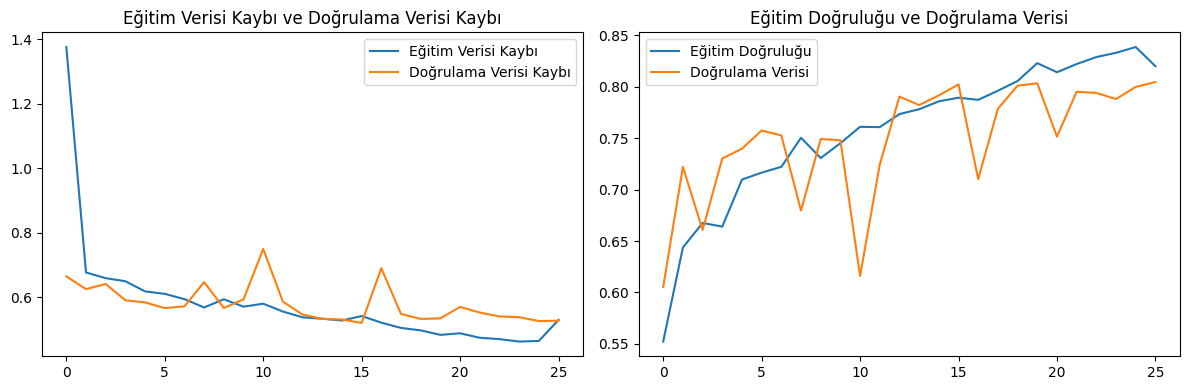

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Verisi Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Verisi Kaybı')
plt.legend()
plt.title('Eğitim Verisi Kaybı ve Doğrulama Verisi Kaybı')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Verisi')
plt.legend()
plt.title('Eğitim Doğruluğu ve Doğrulama Verisi')

plt.tight_layout()
plt.show()

###5. Model Değerlendirmesi

27/27 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.65      0.73       342
         1.0       0.79      0.90      0.84       507

    accuracy                           0.80       849
   macro avg       0.81      0.78      0.79       849
weighted avg       0.80      0.80      0.80       849



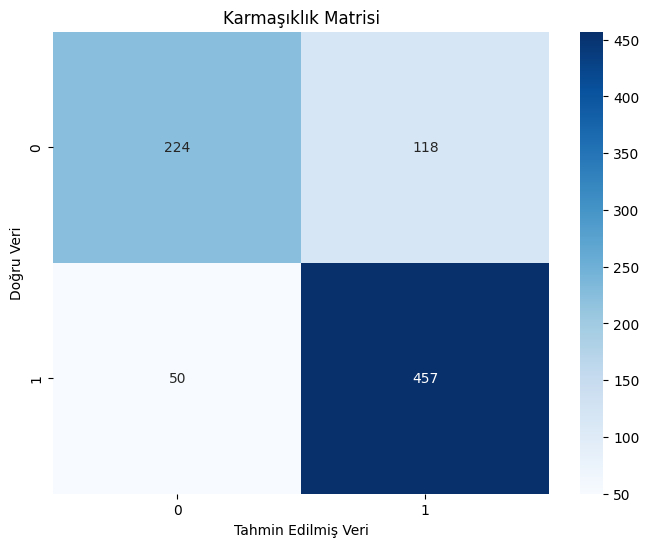

In [ ]:
y_pred = model.predict(X_val)
y_pred_binary = np.round(y_pred).astype(int).flatten()

print(classification_report(y_val, y_pred_binary))

conf_mat = confusion_matrix(y_val, y_pred_binary)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilmiş Veri')
plt.ylabel('Doğru Veri')
plt.title('Karmaşıklık Matrisi')
plt.show()

### SVM


In [ ]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split

X = np.random.rand(100, 2)
y = np.array([0 if np.linalg.norm(x) < 0.5 else 1 for x in X])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)

clf = svm.SVC()

clf.fit(X_train, y_train)


SVC()

In [ ]:
print( "SVM model accuracy:%", clf.score(X_test,y_test)*100)

SVM model accuracy:% 98.0


### Naive Bayes


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

In [ ]:
y_pred = gnb.predict(X_test)

In [ ]:
from sklearn import metrics
print("model accuracy:%", metrics.accuracy_score(y_test, y_pred)*100)

model accuracy:% 94.0
